In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# import original data

In [2]:
property_data = pd.read_csv('NY property data.csv')
property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 32 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1070994 non-null  int64  
 1   BBLE      1070994 non-null  object 
 2   B         1070994 non-null  int64  
 3   BLOCK     1070994 non-null  int64  
 4   LOT       1070994 non-null  int64  
 5   EASEMENT  4636 non-null     object 
 6   OWNER     1039249 non-null  object 
 7   BLDGCL    1070994 non-null  object 
 8   TAXCLASS  1070994 non-null  object 
 9   LTFRONT   1070994 non-null  int64  
 10  LTDEPTH   1070994 non-null  int64  
 11  EXT       354305 non-null   object 
 12  STORIES   1014730 non-null  float64
 13  FULLVAL   1070994 non-null  float64
 14  AVLAND    1070994 non-null  float64
 15  AVTOT     1070994 non-null  float64
 16  EXLAND    1070994 non-null  float64
 17  EXTOT     1070994 non-null  float64
 18  EXCD1     638488 non-null   float64
 19  STADDR    1070318 non

# Cleaning data

### ZIP

In [3]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

29890

In [4]:
for i in range(len(missing_zips)):
    if (property_data.loc[missing_zips[i]+1, 'ZIP'] == property_data.loc[missing_zips[i]-1, 'ZIP']):
        property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [5]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

16437

In [6]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i], 'ZIP'] = property_data.loc[missing_zips[i]-1, 'ZIP']

In [7]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

### STORIES

In [8]:
missing_stories = property_data[property_data['STORIES'].isnull()]
len(missing_stories)

56264

In [9]:
missing_stories['TAXCLASS'].value_counts()

1B    24736
4     22354
3      4635
2      3435
1       897
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [10]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
mean_stories

TAXCLASS
1      2.111641
1A     1.656837
1B     4.000000
1C     3.052748
1D     1.068966
2     16.095110
2A     2.844574
2B     4.004494
2C     4.745097
3      1.333333
4      5.446968
Name: STORIES, dtype: float64

In [11]:
len(property_data[property_data['STORIES']==0])

0

In [12]:
property_data['STORIES'] = property_data['STORIES'].fillna(value=0)

In [13]:
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0) & (property_data["TAXCLASS"]==index), 'STORIES'] = mean_stories[index]

In [14]:
len(property_data[property_data['STORIES']==0])

0

In [15]:
len(property_data[property_data['STORIES'].isnull()])

0

### FULLVAL, AVLAND, AVTOT

In [16]:
property_data['FULLVAL'].replace('NaN',0)
temp_fullval = property_data[property_data['FULLVAL'] != 0]
mean_fullval = temp_fullval.groupby('TAXCLASS')['FULLVAL'].mean()
mean_fullval

TAXCLASS
1     5.698435e+05
1A    3.352842e+05
1B    5.613639e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.998018e+05
2A    8.640037e+05
2B    1.252989e+06
2C    7.728799e+05
3     1.112765e+05
4     3.211928e+06
Name: FULLVAL, dtype: float64

In [17]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND'] != 0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()
mean_avland

TAXCLASS
1      14896.433976
1A      2247.369138
1B     14781.268478
1C      8225.658898
1D    709303.793103
2      90830.095031
2A     31363.390619
2B     54446.810503
2C     25639.066531
3      43368.352941
4     600949.433397
Name: AVLAND, dtype: float64

In [18]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT'] != 0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()
mean_avtot

TAXCLASS
1     2.501609e+04
1A    1.436972e+04
1B    1.478410e+04
1C    2.898447e+04
1D    1.166866e+06
2     3.599121e+05
2A    7.961158e+04
2B    1.785982e+05
2C    1.170444e+05
3     5.007444e+04
4     1.488705e+06
Name: AVTOT, dtype: float64

In [19]:
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0) & (property_data['TAXCLASS']==index), 'FULLVAL'] = mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0) & (property_data['TAXCLASS']==index), 'AVLAND'] = mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0) & (property_data['TAXCLASS']==index), 'AVTOT'] = mean_avtot[index]

### 'LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH'

In [20]:
# as these 4 values do not have NAs, we just need to replace 0s. 
# calculate groupwise average. 1st replace 0 by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [21]:
# calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()
mean_BLDDEPTH

TAXCLASS
1      41.556940
1A     44.949251
1B     82.666667
1C     60.094862
1D     36.862069
2     108.005699
2A     62.430662
2B     66.587020
2C     68.660429
3      33.750000
4      87.820730
Name: BLDDEPTH, dtype: float64

In [22]:
# impute values
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]


# Build variables

In [23]:
data = property_data[['ZIP', 'STORIES', 'FULLVAL',
                      'AVLAND', 'AVTOT', 'LTFRONT',
                      'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 
                      'TAXCLASS', 'B', 'RECORD']].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 12 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   ZIP       1070994 non-null  float64
 1   STORIES   1070994 non-null  float64
 2   FULLVAL   1070994 non-null  float64
 3   AVLAND    1070994 non-null  float64
 4   AVTOT     1070994 non-null  float64
 5   LTFRONT   1070994 non-null  float64
 6   LTDEPTH   1070994 non-null  float64
 7   BLDFRONT  1070994 non-null  float64
 8   BLDDEPTH  1070994 non-null  float64
 9   TAXCLASS  1070994 non-null  object 
 10  B         1070994 non-null  int64  
 11  RECORD    1070994 non-null  int64  
dtypes: float64(9), int64(2), object(1)
memory usage: 98.1+ MB


In [24]:
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [25]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 16 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   ZIP       1070994 non-null  object 
 1   STORIES   1070994 non-null  float64
 2   FULLVAL   1070994 non-null  float64
 3   AVLAND    1070994 non-null  float64
 4   AVTOT     1070994 non-null  float64
 5   LTFRONT   1070994 non-null  float64
 6   LTDEPTH   1070994 non-null  float64
 7   BLDFRONT  1070994 non-null  float64
 8   BLDDEPTH  1070994 non-null  float64
 9   TAXCLASS  1070994 non-null  object 
 10  B         1070994 non-null  int64  
 11  RECORD    1070994 non-null  int64  
 12  zip3      1070994 non-null  object 
 13  ltsize    1070994 non-null  float64
 14  bldsize   1070994 non-null  float64
 15  bldvol    1070994 non-null  float64
dtypes: float64(11), int64(2), object(3)
memory usage: 130.7+ MB


In [27]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 25 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   ZIP       1070994 non-null  object 
 1   STORIES   1070994 non-null  float64
 2   FULLVAL   1070994 non-null  float64
 3   AVLAND    1070994 non-null  float64
 4   AVTOT     1070994 non-null  float64
 5   LTFRONT   1070994 non-null  float64
 6   LTDEPTH   1070994 non-null  float64
 7   BLDFRONT  1070994 non-null  float64
 8   BLDDEPTH  1070994 non-null  float64
 9   TAXCLASS  1070994 non-null  object 
 10  B         1070994 non-null  int64  
 11  RECORD    1070994 non-null  int64  
 12  zip3      1070994 non-null  object 
 13  ltsize    1070994 non-null  float64
 14  bldsize   1070994 non-null  float64
 15  bldvol    1070994 non-null  float64
 16  r1        1070994 non-null  float64
 17  r2        1070994 non-null  float64
 18  r3        1070994 non-null  float64
 19  r4        1070994 non

In [29]:
nine_vars = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9']

zip5_mean = data.groupby('ZIP')[nine_vars].mean()
zip3_mean = data.groupby('zip3')[nine_vars].mean()
taxclass_mean = data.groupby('TAXCLASS')[nine_vars].mean()
borough_mean = data.groupby('B')[nine_vars].mean()

data = data.join(zip5_mean, on='ZIP', rsuffix = '_zip5')
data = data.join(zip3_mean, on='zip3', rsuffix = '_zip3')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix = '_taxclass')
data = data.join(borough_mean, on='B', rsuffix = '_boro')

rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']

for var in nine_vars:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [30]:
data.drop(columns = ['ZIP', 'STORIES', 'FULLVAL',
                     'AVLAND', 'AVTOT', 'LTFRONT',
                     'LTDEPTH', 'BLDFRONT', 'BLDDEPTH',
                     'TAXCLASS', 'B', 
                     'zip3', 'ltsize', 'bldsize', 'bldvol'],
          inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 46 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   RECORD       1070994 non-null  int64  
 1   r1           1070994 non-null  float64
 2   r2           1070994 non-null  float64
 3   r3           1070994 non-null  float64
 4   r4           1070994 non-null  float64
 5   r5           1070994 non-null  float64
 6   r6           1070994 non-null  float64
 7   r7           1070994 non-null  float64
 8   r8           1070994 non-null  float64
 9   r9           1070994 non-null  float64
 10  r1_zip5      1070994 non-null  float64
 11  r2_zip5      1070994 non-null  float64
 12  r3_zip5      1070994 non-null  float64
 13  r4_zip5      1070994 non-null  float64
 14  r5_zip5      1070994 non-null  float64
 15  r6_zip5      1070994 non-null  float64
 16  r7_zip5      1070994 non-null  float64
 17  r8_zip5      1070994 non-null  float64
 18  r9

# Z scale and PCA

In [31]:
data_orig = data.copy()

In [32]:
data.drop(columns='RECORD', inplace=True)
data = (data - data.mean()) / data.std()
data.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,1.192887e-14,-1.956271e-14,-1.777944e-15,-9.639809e-15,-1.225623e-15,6.077808e-15,-2.149181e-14,2.557510e-16,2.467938e-15,3.529330e-14,...,2.651688e-14,1.416381e-14,-2.315764e-14,2.107545e-15,-2.663685e-16,3.334107e-15,2.559602e-15,-2.050327e-14,-1.902262e-15,-1.139079e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.170794e-01,-2.330264e-01,-1.670424e-01,-6.172831e-02,-2.927850e-02,-2.170250e-02,-1.012244e-01,-4.391781e-02,-3.271184e-02,-3.514611e-01,...,-1.335327e-01,-3.292877e-01,-2.334633e-01,-1.038394e-01,-4.659210e-02,-3.246591e-02,-2.771338e-02,-8.661033e-02,-4.259928e-02,-3.929067e-02
25%,-2.107938e-01,-1.597743e-01,-1.209028e-01,-4.925107e-02,-2.355366e-02,-1.900615e-02,-8.214703e-02,-3.091588e-02,-2.339241e-02,-2.029755e-01,...,-8.399919e-02,-2.007440e-01,-1.567837e-01,-7.387945e-02,-3.626873e-02,-2.546635e-02,-2.403808e-02,-6.636767e-02,-2.781447e-02,-2.708941e-02
50%,-9.171668e-02,-2.112265e-02,-9.515198e-03,-3.624134e-02,-1.408563e-02,-1.070379e-02,-6.965849e-02,-2.306247e-02,-1.485576e-02,-3.364188e-02,...,-2.424407e-02,-5.649824e-02,-1.668091e-02,-1.121917e-02,-1.771892e-02,-1.221901e-02,-1.282995e-02,-4.368292e-02,-1.636408e-02,-1.654421e-02
75%,4.407763e-02,5.920410e-02,5.631929e-02,-2.132744e-02,-8.557022e-03,-6.122879e-03,-5.103303e-02,-1.590614e-02,-7.793980e-03,7.882297e-02,...,1.669894e-02,7.921351e-02,6.022658e-02,2.622304e-02,-3.647703e-04,-4.708114e-03,-6.187080e-03,-1.811434e-02,-7.297386e-03,-7.309352e-03
max,5.127652e+02,4.710073e+02,7.355728e+02,8.618165e+02,5.018369e+02,7.631587e+02,5.730332e+02,6.415456e+02,7.002223e+02,5.086535e+02,...,5.896402e+02,4.618636e+02,4.675608e+02,8.334646e+02,9.388877e+02,5.531192e+02,6.241236e+02,7.261511e+02,7.526293e+02,5.814213e+02


(0.0, 1.0)

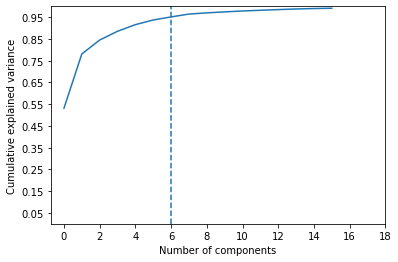

In [33]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)


In [274]:
pca = PCA(n_components = 7)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape


(1070994, 7)

In [275]:
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-1.947178e-16,-3.140532e-16,1.632388e-16,-3.549551e-15,2.796430e-15,-5.096815e-16,-2.140157e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.473123e-01,-3.121770e+02,-4.693497e+02,-1.839581e+02,-3.911585e+02,-2.618059e+02,-2.129470e+02
25%,-6.862403e-02,-9.947863e-02,-6.131603e-02,-1.448078e-01,-1.114985e-01,-7.018083e-02,-1.120009e-01
50%,-1.944495e-02,-4.105365e-02,1.099319e-02,-2.396815e-02,-5.630875e-02,7.533849e-04,4.435278e-03
75%,1.192503e-02,2.033200e-02,1.500593e-01,5.505622e-02,3.222938e-02,1.235224e-01,8.384094e-02
max,5.229280e+02,6.036698e+02,6.141779e+02,3.898521e+02,4.478940e+02,4.230685e+02,3.327260e+02


# Computing scores

# Score 1

In [276]:
p=1
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p


## Score 2

In [278]:
from keras.models import Model
from keras.layers import Input, Dense
# placeholder for input
data_in = Input(shape=(7,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(7,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=5, shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca

p=4
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop


Epoch 1/5
33469/33469 [==============================] - 20s 601us/step - loss: 0.9943 - val_loss: 0.9264
Epoch 2/5
33469/33469 [==============================] - 19s 567us/step - loss: 0.7185 - val_loss: 0.9257
Epoch 3/5
33469/33469 [==============================] - 19s 557us/step - loss: 0.9697 - val_loss: 0.9253
Epoch 4/5
33469/33469 [==============================] - 20s 608us/step - loss: 0.9245 - val_loss: 0.9254
Epoch 5/5
33469/33469 [==============================] - 21s 619us/step - loss: 0.8376 - val_loss: 0.9249


In [279]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2

(0.1, 2124071.690729293)

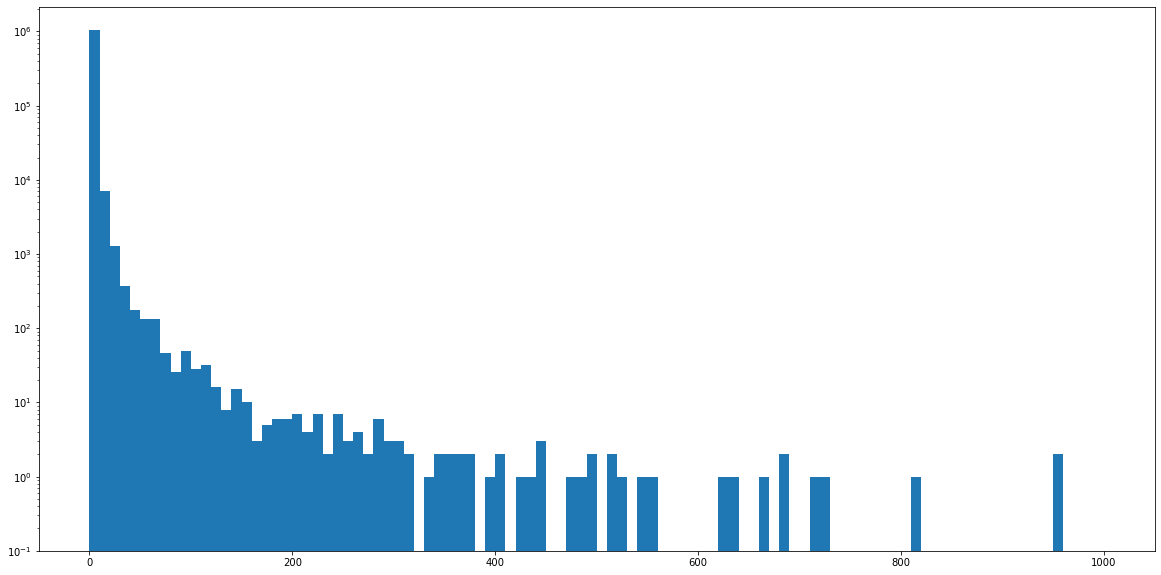

In [280]:
plt.hist(score1, bins = 100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2142259.8290481246)

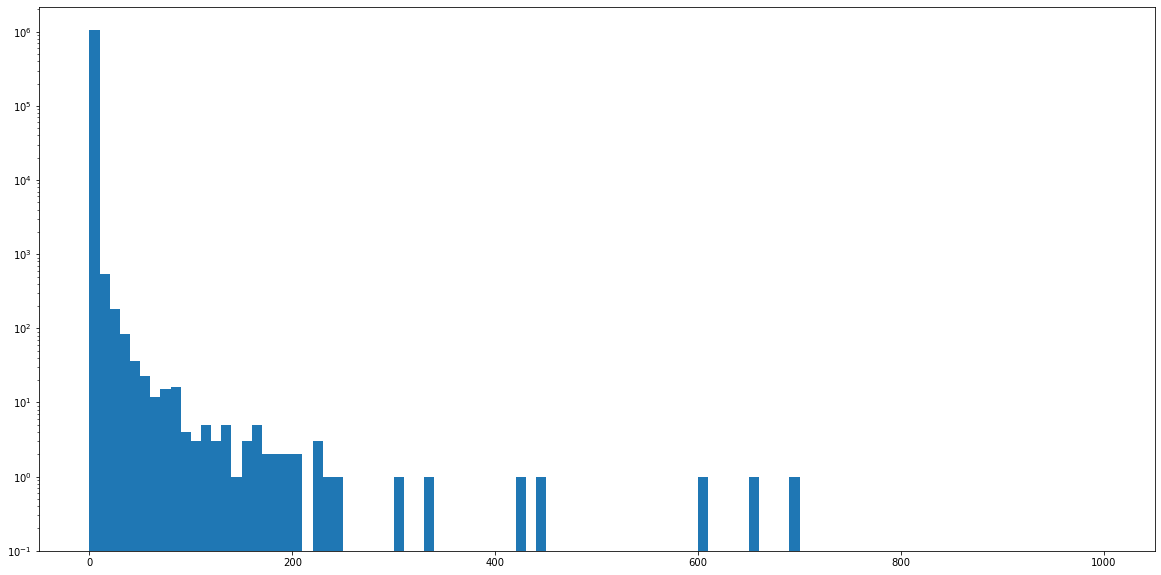

In [281]:
plt.hist(score2, bins = 100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

C:\Users\sirwo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='final', ylabel='Density'>

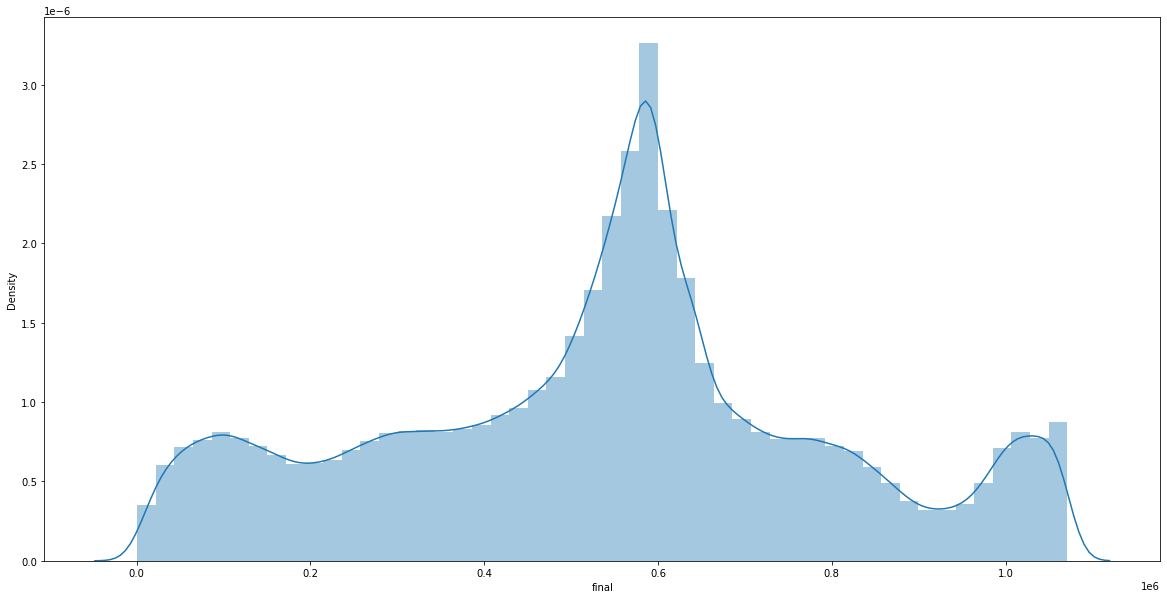

In [282]:
sns.distplot(scores['final'])

In [283]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   score1       1070994 non-null  float64
 1   score2       1070994 non-null  float64
 2   score1 rank  1070994 non-null  float64
 3   score2 rank  1070994 non-null  float64
 4   final        1070994 non-null  float64
dtypes: float64(5)
memory usage: 40.9 MB


## Append back to original data

In [284]:
data_with_scores = pd.concat([property_data, scores], axis = 1)

In [285]:
data_with_scores.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,...,8613000.0,NaN,FINAL,2010/11,AC-TR,4.932747,1.095585,1049354.0,1056142.0,1052748.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,...,80690400.0,NaN,FINAL,2010/11,AC-TR,204.059103,54.449376,1070906.0,1070889.0,1070897.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,...,40179510.0,NaN,FINAL,2010/11,AC-TR,0.552108,0.132014,517960.0,893823.0,705891.5
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,...,15750000.0,NaN,FINAL,2010/11,AC-TR,0.769777,0.201275,653605.0,982779.0,818192.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,...,107758350.0,NaN,FINAL,2010/11,AC-TR,93.782664,30.724811,1070760.0,1070763.0,1070761.5


In [286]:
top100 = data_with_scores.sort_values(['final'], ascending = False).head(100).index
print(top100)

Int64Index([ 917941,  565391,   85885,  684703,   67128,  915468,  690832,
              44247, 1059882,  116646,  565397,   39769,  501142,  556608,
             106680,  738017,  151043,  957063, 1065869,   33750,     418,
             964933,  918203,  252833,  927226,  139725,   48220,  918857,
              19241,  985596,  932860,  915469,  104410,  330290,  771149,
             684562,  964947,  610681,  752487,   97083,  245572,   60468,
             691878,  720599,  934792,  665157,  649674,  153069,  973911,
             464854,   56135,  556910,  773561,  764311,   47983,  918304,
             923882,  216947,  177645,  131602,   86945,   85883,  340899,
             109066,  209711,  991516,  621688,  817348,  918204,  209713,
             638992,  248664,  917059,  451671,  243058,  994812,  994814,
             994816,  994818,  174538,   12075,  334956,  994820,  992070,
              26242,  330291,  773734,   56133,   88388,  991782,   79816,
             259234,  918

In [287]:
data_zs_top100 = data_with_scores.iloc[top100]
data_zs_top100

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
917941,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.000000,...,4.501180e+09,NaN,FINAL,2010/11,AC-TR,2209.936561,695.304049,1070994.0,1070994.0,1070994.0
565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117.000000,...,8.484847e+08,NaN,FINAL,2010/11,AC-TR,2025.314102,659.398368,1070993.0,1070993.0,1070993.0
85885,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000.000000,...,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1921.854967,606.052380,1070992.0,1070992.0,1070992.0
684703,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2.000000,...,NaN,NaN,FINAL,2010/11,AC-TR,1278.165719,448.163505,1070990.0,1070991.0,1070990.5
67128,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840.000000,...,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1328.074705,427.753202,1070991.0,1070990.0,1070990.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116645,116646,1015410001,1,1541,1,NaN,YORKVILLE PLAZA ASSOC,D6,2,25.000000,...,NaN,NaN,FINAL,2010/11,AC-TR,191.921334,59.040155,1070899.0,1070900.0,1070899.5
85961,85962,1012600014,1,1260,14,NaN,WEST 44TH STREET OWNE,H2,4,18.000000,...,NaN,NaN,FINAL,2010/11,AC-TR,193.798166,56.632608,1070901.0,1070894.0,1070897.5
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.000000,...,8.069040e+07,NaN,FINAL,2010/11,AC-TR,204.059103,54.449376,1070906.0,1070889.0,1070897.5
33563,33564,1006890017,1,689,17,NaN,"HLP PROPERTIES, LLC",G6,4,380.000000,...,NaN,NaN,FINAL,2010/11,AC-TR,201.275753,53.988141,1070904.0,1070887.0,1070895.5


In [296]:
data_zs_top100.to_csv('new_top100.csv', index=False)

In [289]:
data2 = data_orig.copy()
data2.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,...,2.794864,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705
1,2,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,...,25.310494,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469
2,3,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,...,0.351313,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140
3,4,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,...,1.684761,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102
4,5,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,...,216.090453,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838


In [290]:
data2 = data2.iloc[top100]
data2.set_index('RECORD',inplace=True)

In [298]:
data2.head(20)

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,569.016486,6.609119e+04,2.203040e+04,2727.496301,316798.323817,105599.441272,7102.148507,824913.581531,274971.193844,5.246009,...,2459.956835,3.378358,115.064478,75.255911,423.842882,11701.016994,7035.449357,525.167956,17668.529358,11306.755390
565392,342379.210193,7.644795e+05,1.403496e+05,154070.644587,344015.793345,63157.301566,154070.644587,344015.793345,63157.301566,1448.251253,...,565.020043,1403.611486,1306.850954,527.809389,20152.205184,17037.870092,6336.338637,8385.114593,8325.319455,3420.475788
85886,117.023333,1.097094e+06,1.097094e+06,52.425000,491484.375000,491484.375000,52.660500,493692.187500,493692.187500,0.528007,...,4416.686177,0.329010,2003.713710,8027.478572,1.545811,7831.876915,22521.648813,0.570814,3454.769177,14798.920002
684704,140340.974007,1.719163e+02,4.297907e+01,3695.317120,4.526726,1.131681,3696.025149,4.527593,1.131898,640.632202,...,0.999982,833.230686,0.299305,0.146817,574.238674,0.167196,0.075397,273.302363,0.096975,0.046543
67129,54689.944325,1.086736e+06,1.995121e+05,23730.100233,471537.320539,86568.771925,24610.474946,489031.116579,89780.429568,96.512394,...,803.196794,153.760195,1984.796150,1459.837714,699.709267,7514.017623,3966.904298,266.765456,3422.151840,2691.258700
915469,541.225410,1.654176e+05,4.135439e+04,32.473525,9925.054104,2481.263526,32.473525,9925.054104,2481.263526,4.465243,...,2192.085373,3.213357,287.991287,141.266752,5.046266,366.584095,165.311517,2.401253,212.581189,102.029014
690833,742.923804,6.050000e+05,2.016667e+05,317.738073,258750.000000,86250.000000,334.315712,272250.000000,90750.000000,3.391318,...,811.870799,4.410878,1053.302441,688.894059,49.375327,9556.989162,5746.313614,24.720956,5831.225507,3731.620165
44248,577.944015,4.490625e+05,4.490625e+05,247.586873,192375.000000,192375.000000,260.074807,202078.125000,202078.125000,1.658375,...,1807.838333,1.624883,820.160253,3285.808160,7.300383,3065.524355,8815.340651,2.819083,1414.106391,6057.495099
1059883,128477.100866,5.675637e+02,1.041981e+02,24037.977336,106.190776,19.495392,59548.213689,263.061693,48.295070,899.479971,...,0.432059,832.692534,1.212988,0.407497,2259.165418,4.819389,1.533866,2556.478664,7.483342,2.421102


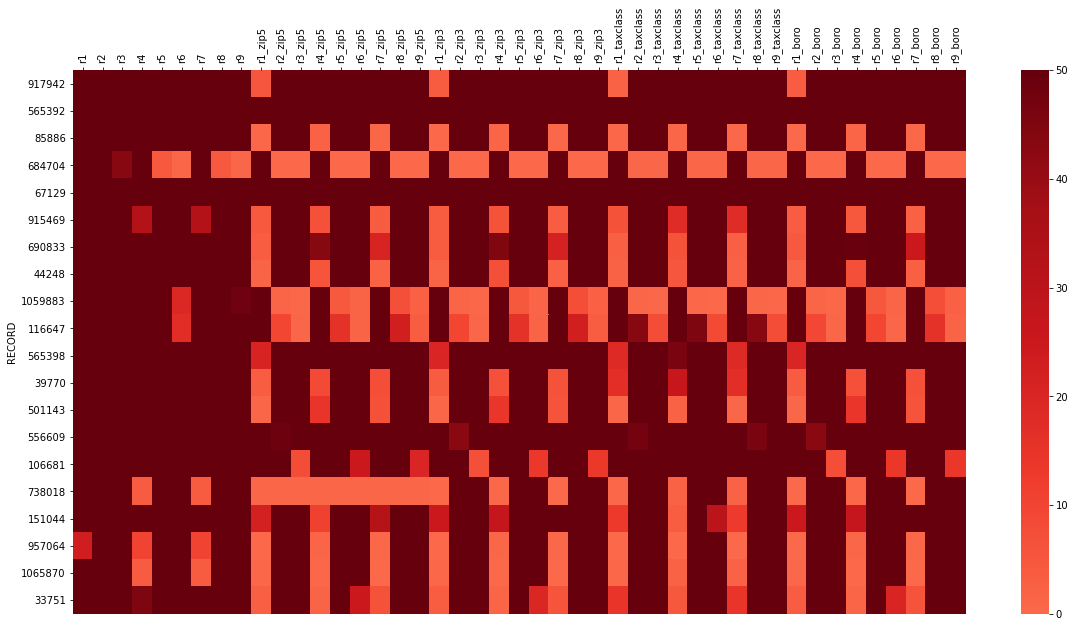

In [291]:
data_heatmap = data2.abs().head(20)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [295]:
print(f'Percentage of similarity: {top100.isin(top100_orig).sum()} %')

Percentage of similarity: 94 %
